## Training a neural network to predict the position of body features from VR controllers

In [45]:
%matplotlib inline
from __future__ import print_function
import glob
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPRegressor

### Reading the recorded data

The data recorded are stored in CSV formatted files, which we read in as pandas data frames and extract the input and output features

Note: The direction of the headset and controllers are stored in the data files as well, in the form of quaternions, with labels 'HeadsetQuaternionX', 'HeadsetQuaternionY', 'HeadsetQuaternionZ', 'HeadsetQuaternionW' and similar for LController and RController. If you are familiar with quaternion math (In a left-handed coordinate system), try to include these features in the training.

In [4]:
# Create list of data files
data_files = glob.glob('../../data/*_steamVRPositions_*')

# The input features are XYZ positions of the headset and controllers
input_features = ['Headset', 'LController', 'RController']
# The output features are XYZ positions of the front, back, elbows and knees
output_features = ['Front', 'Back', 'LeftElbow', 'RightElbow', 'LeftKnee', 'RightKnee']
# Create the labels to be read
input_labels = [x+y for x in input_features for y in 'XYZ']
output_labels = [x+y for x in output_features for y in 'XYZ']
print('Input labels are: \n', ", ".join(input_labels))
print('Output labels are: \n', ", ".join(output_labels))

# Read in the needed columns from the data files
# The data is recorded with the simulation box size as a reference, which we need to read to
# properly scale the data.
all_input_data = []
all_output_data = []
all_box_scales = []
all_player_ids = []
# Read each data file
for f in data_files:
    fname = f.split('/')[-1]
    # Keep track of the player generating the data
    if fname[0] == 'f':
        # Player Felix
        player_id = 0
    elif fname[0] == 'r':
        # Player Rob
        player_id = 1
    elif fname[0] == 'l':
        # Player Lisa
        player_id = 2
    elif fname[0] == 'h':
        # Player Helen
        player_id = 3
    elif fname[0] == 's':
        # Player Silvia
        player_id = 4
    else:
        # Random players
        player_id = 5
        
    df = pd.read_csv(f)
    # drop rows with NaN
    df = df.dropna()
    all_input_data.append(df[input_labels].values)
    all_output_data.append(df[output_labels].values)
    all_box_scales.append(df['Scale'].values)
    all_player_ids.extend([player_id]*len(df))

# Join data together as a single array
data_in = np.concatenate(all_input_data)
data_out = np.concatenate(all_output_data)
# Make box_scales a 2d-array for easier maths operations later
box_scales = np.concatenate(all_box_scales)[:,None]
player_ids = np.asarray(all_player_ids)
print('Shape of data_in:', data_in.shape)
print('Shape of data_out', data_out.shape)
print('Shape of box_scales', box_scales.shape)
lol = data_in.copy()

Input labels are: 
 HeadsetX, HeadsetY, HeadsetZ, LControllerX, LControllerY, LControllerZ, RControllerX, RControllerY, RControllerZ
Output labels are: 
 FrontX, FrontY, FrontZ, BackX, BackY, BackZ, LeftElbowX, LeftElbowY, LeftElbowZ, RightElbowX, RightElbowY, RightElbowZ, LeftKneeX, LeftKneeY, LeftKneeZ, RightKneeX, RightKneeY, RightKneeZ
Shape of data_in: (32454, 9)
Shape of data_out (32454, 18)
Shape of box_scales (32454, 1)


### Preprocessing

When recording, people will move around the room (translation), change the direction they're facing (rotation) and the height will vary from person to person (height scaling). In addition, the positional data is recorded relative to the simulation box size (box scaling).
The machine learning algorithm will be more effective if we normalise the data to a common reference, which can be done in many different ways. The way we have chosen centers each frame such that the average of the X and Z components of the headset and controllers are zero. Then we rotate such that the head is placed on the negative X-axis with Z-component of zero (we assume the head is facing the center).

Note: If you can think of an alternative way of normalising the data, try to implement this and compare the results.

In [5]:
# Scale by VR-box size
data_in = lol.copy()
data_in *= box_scales
data_out *= box_scales

# Shift vertically so feet are at approx y=0
# The floor_position is a known constant
floor_position = 1.0

# Only change the Y-components (indices 1, 4, ...)
data_in[:,1::3] += floor_position
data_out[:,1::3] += floor_position

# Scale by each persons height from the first frame
data_in /= data_in[0,1]
data_out /= data_in[0,1]

# Get mean x and z coordinates of head and hands
# Store as 2d-array for easier math
mean_x = np.mean(data_in[:,::3], axis=1)[:,None]
mean_z = np.mean(data_in[:,2::3], axis=1)[:,None]

# center the data
data_in[:,::3] -= mean_x
data_out[:,::3] -= mean_x
data_in[:,2::3] -= mean_z
data_out[:,2::3] -= mean_z

# Rotate head onto the negative X-axis
def rotate(array1, array2, angle):
    """ Rotate anti-clockwise around (0,1,0) by angle radians.
        X' = cos(angle) * X - sin(angle) * Z
        Z' = sin(angle) * X + cos(angle) * Z
    """
    c = np.cos(angle)
    s = np.sin(angle)
    array1[:,::3], array1[:,2::3] = (c * array1[:,::3] - s * array1[:,2::3], s * array1[:,::3] + c * array1[:,2::3])
    array2[:,::3], array2[:,2::3] = (c * array2[:,::3] - s * array2[:,2::3], s * array2[:,::3] + c * array2[:,2::3])

# Calculate the rotation angles (2d-array to make the math easier)
head_angles = np.pi - np.arctan2(data_in[:,2], data_in[:,0])[:,None]
# Rotate the input and output features
rotate(data_in, data_out, head_angles)
# Verify that the Z-component of the headset is now zero
print('Headset Z-component min and max:', data_in[:,2].min(), data_in[:,2].max())

# Since the Z-component is zero, we don't need it for training, and will ignore it from here on
data_in = np.delete(data_in, 2, axis=1)
print('Input data shape after removing axis:', data_in.shape)


Headset Z-component min and max: -1.94289029309e-16 4.23272528138e-16
Input data shape after removing axis: (32454, 8)


### Outlier removal
Due to occlusion of the sensors sometimes one of the controllers will drift off. This is fine for the input features, as the occlusion can happen during use, but it's something that we'd like to remove from the output features. Here we use the IsolationForrest method implemented in scikit-learn to classify where occlusion might have occured. (http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

Note: Other methods could be used as well. Take a look at http://scikit-learn.org/stable/modules/outlier_detection.html and try to use a different method.

Note: When occlusion of a sensor happens, each drift should be constant in a specific direction (a drift at a later time might happen with a different rate in a different direction though). Try to detect outliers by using this information.

In [6]:
# Our estimations of the number of outliers in the output features
outlier_fraction = 0.05

# Construct and fit the isolation forrest
clf = IsolationForest(max_samples=1.0, contamination=outlier_fraction)
clf.fit(data_out)

# Predict which frames have outliers
prediction = clf.predict(data_out)

# prediction will be -1 if the point is an outlier and 1 if it is not.
# We convert this output to a boolean array
inliers = np.asarray((prediction+1) // 2, dtype=bool)

# Only retain the frames that isn't detected as outliers
n_data_before = data_in.shape[0]
data_in_pruned = data_in[inliers]
data_out_pruned = data_out[inliers]
player_ids_pruned = player_ids[inliers]
n_data_after = data_in_pruned.shape[0]
print('Removed %d out of %d data points (%.1f %%)' % (n_data_before - n_data_after, n_data_before,(1-n_data_after/n_data_before)*100 ))

Removed 1623 out of 32454 data points (5.0 %)


We can visualise the data before and after outlier removal to see if it looks like we would expect.

Note: Try to change the outlier_fraction and view the effect.

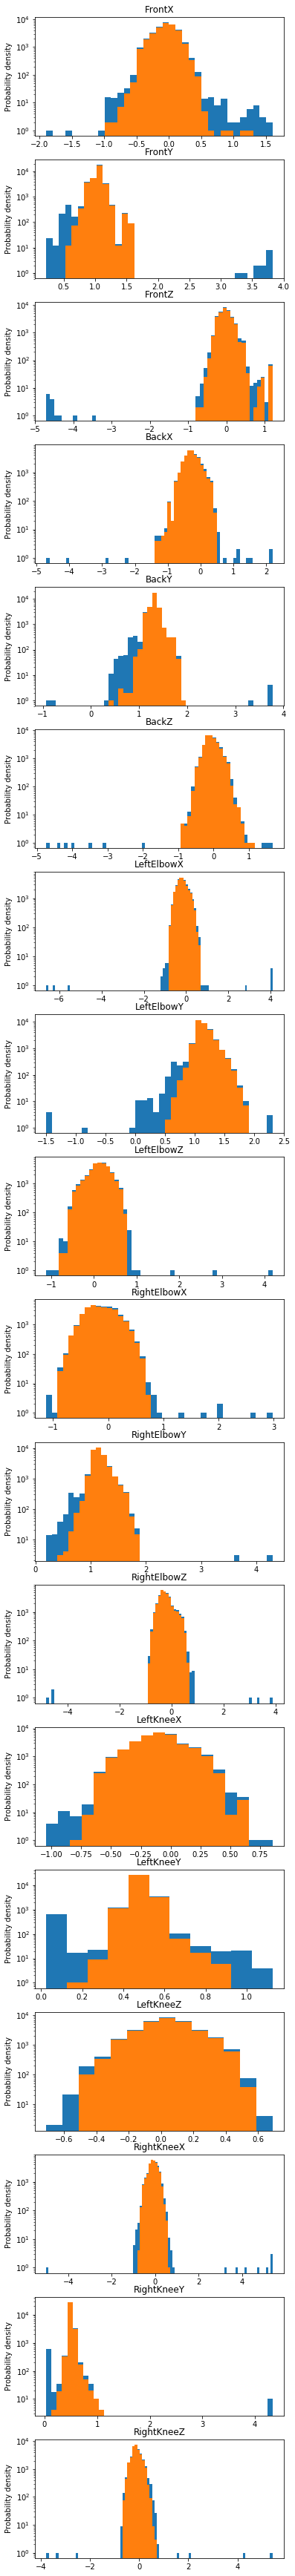

In [7]:
def plot_outliers(data, data_pruned, labels):
    n_features = len(labels)
    fig, axes = plt.subplots(n_features, 1)
    
    fig.set_size_inches(6, 3.5*n_features)
    for i in range(n_features):
        min_value = min(data[:,i])
        max_value = max(data[:,i])
        binwidth = 0.1
        bins = np.arange(min(data[:, i]), max(data[:, i]) + binwidth, binwidth)
        axes[i].set_yscale('log') # Set logarithmic y axis
        axes[i].set_title('%s'%labels[i])
        axes[i].set_ylabel('Probability density')
        axes[i].hist(data[:, i], bins=bins, stacked=False)
        axes[i].hist(data_pruned[:, i], bins=bins, stacked=False)
    
    plt.show()

plot_outliers(data_out, data_out_pruned, output_labels)


### Split data into training, test and validation data
To avoid overfitting, we split the data into a training set, validation set and test set. This is known as cross validation. The training set is what the neural network is actually trained on. The hyper-parameters of the neural network (learning rate, regularisation, nodes in each layer etc.) can then be selected to optimise the predictive performance on the validation set, which has not been included in the training. This makes sure that the prediction of the neural network is transferable ie. still performs well on people not included in the training.
Finally, the test set is used to measure the performance of the selected model.

To keep things simple we use Felix' data as validation set and Silvia's data as test set. More robust ways of performing cross validation can be used, which you can read more about at http://scikit-learn.org/stable/modules/cross_validation.html and http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html

In [8]:
train_in = data_in_pruned[np.where((player_ids_pruned != 0) & (player_ids_pruned != 4))]
train_out = data_out_pruned[np.where((player_ids_pruned != 0) & (player_ids_pruned != 4))]
val_in = data_in_pruned[np.where(player_ids_pruned == 0)]
val_out = data_out_pruned[np.where(player_ids_pruned == 0)]
test_in = data_in_pruned[np.where(player_ids_pruned == 4)]
test_out = data_out_pruned[np.where(player_ids_pruned == 4)]
print('Number of training points:', train_in.shape[0])
print('Number of validation points:', val_in.shape[0])
print('Number of test points:', test_in.shape[0])

Number of training points: 23454
Number of validation points: 4690
Number of test points: 2687


### Training the neural network
We use the multilayer perceptron implementation in scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

When more than a few hyperparameters affects the performance of the model, it becomes impossible to optimise the hyperparameters with a standard grid search. Instead the optimisation is typically done with genetic algorithms or gaussian processes, however any thorough search will be very costly, so here you can just change the hyper parameters by hand.

Note: Here we predict all 18 output features with one network. You can definately get better results by training a network a subset of the features. E.g. only predicting the left elbow or even just the X-coordinate of the left elbow.

Note: In principle we have twice as many data points if we mirror the body, such that left hand becomes right and vice versa. Try to implement this and see if it improved the predictions

In [24]:
estimator = MLPRegressor(alpha = 1e-4 , hidden_layer_sizes=(64,64), batch_size=2048, early_stopping = True,
                         max_iter = 10000, learning_rate_init = 0.01, learning_rate='adaptive')
estimator.fit(train_in, train_out)
predicted_out = estimator.predict(val_in)
val_score = estimator.score(val_in, val_out)
score.append(val_score)
test_score = np.median(score)
print('Pearson correlation on test data: %.3f' % test_score)

Pearson correlation on test data: 0.208


Once we're happy with our choice of hyper parameters, we can include the validation set in the training as well for the final prediction

In [25]:
train_val_in = data_in_pruned[np.where(player_ids_pruned != 4)]
train_val_out = data_out_pruned[np.where(player_ids_pruned != 4)]
estimator.fit(train_val_in, train_val_out)
predicted_out = estimator.predict(test_in)

Scatter plots comparing true and predicted values of (x,y,z), here for LeftElbow, indicating the machine learning performance.

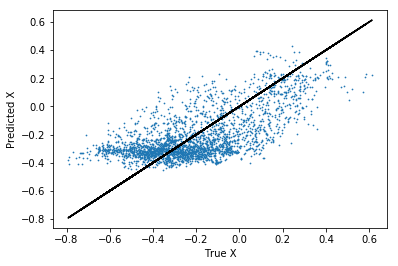

In [28]:
plt.plot(test_out[:,6],test_out[:,6],'k')
plt.scatter(test_out[:,6],predicted_out[:,6],s=0.5) # Predicted vs true of X coordinates
plt.xlabel("True X")
plt.ylabel("Predicted X")
plt.show()

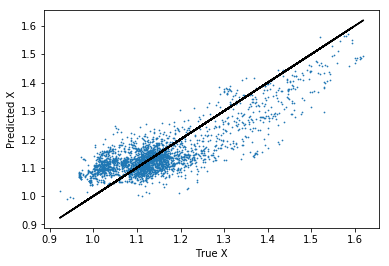

In [27]:
plt.plot(test_out[:,7],test_out[:,7], 'k')
plt.scatter(test_out[:,7],predicted_out[:,7],s=0.5) # Predicted vs true of X coordinates
plt.xlabel("True X")
plt.ylabel("Predicted X")
plt.show()

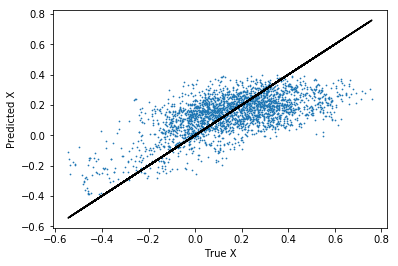

In [29]:
plt.plot(test_out[:,8],test_out[:,8], 'k')
plt.scatter(test_out[:,8],predicted_out[:,8],s=0.5) # Predicted vs true of X coordinates
plt.xlabel("True X")
plt.ylabel("Predicted X")
plt.show()

Make violin plots showing the distribution of error for each feature in Euclidean space

In [34]:
# list of lists of distances between predicted and target for each target position
targets_dist = [[] for i in range(test_out.shape[1] // 3)]
for test, pred in zip(test_out, predicted_out): 
    for i in range(len(test) // 3): 
        test_vec = np.array([test[i * 3 + j] for j in range(3)])
        pred_vec = np.array([pred[i * 3 + j] for j in range(3)])
        dist = np.linalg.norm(test_vec - pred_vec)
        targets_dist[i].append(dist)
# convert into numpy array
targets_dist = np.array(targets_dist)
print(targets_dist.shape)

(6, 2687)


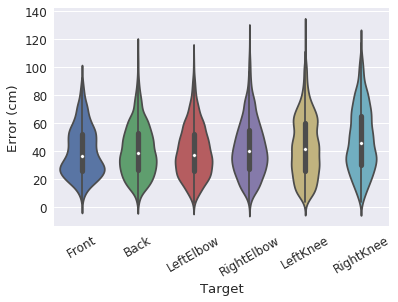

In [43]:
sbn.set(font_scale=1.2)
# Scale by silvias height
scaled_dist = targets_dist * 172
df = pd.DataFrame(scaled_dist.T, columns=x)
meltdf = df.melt(var_name='Target', value_name='Error (cm)')
ax = sbn.violinplot(x=meltdf['Target'], y=meltdf['Error (cm)'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

### Render predicted positions using Unity renderer.

In [52]:
sys.path.append('../rendering')
import AvatarServer

In [56]:
try:
    del server
except:
    print('No server to delete') 

In [57]:
server = AvatarServer.AvatarServer(port=54321)

Connect to the client. This will block until a client connect.
Then send all the features, targets and predicted. 

In [60]:
import copy as cp
server.connect_to_client()

# Add back in the Z-component of the head that we removed earlier
full_test_in = np.zeros((test_in.shape[0],test_in.shape[1]+1))
full_test_in[:,:2] = test_in[:,:2]
full_test_in[:,3:] = test_in[:,2:]

for f, t, p in zip(full_test_in, test_out, predicted_out):
    # TODO - Wrap this up in a nice method.\n",
    feature_dict = AvatarServer.generate_dictionary_for_data(f, input_labels)
    target_dict = AvatarServer.generate_dictionary_for_data(t, output_labels)
    pred_dict = AvatarServer.generate_dictionary_for_data(p, output_labels)
    message = AvatarServer.merge_dictionaries(feature_dict, target_dict, pred_dict)
    server.send_object(message)

Waiting for client to connect...
Got a connection from ('127.0.0.1', 34639)
('Transmitting string', '{"Headset":[-0.0344,0.8681,0.0],"LController":[-0.0303,0.5685,0.0773],"RController":[0.0646,0.6073,-0.0773],"Front":[-0.0694,0.9822,0.0627],"Back":[-0.2437,1.3078,0.0023],"LeftElbow":[-0.2974,1.1175,0.1532],"RightElbow":[-0.1841,1.0978,-0.1018],"LeftKnee":[-0.1306,0.4854,0.0877],"RightKnee":[-0.1189,0.4905,-0.0112]}\n')
('Transmitting string', '{"Headset":[-0.0335,0.8793,0.0],"LController":[-0.0048,0.5768,0.0917],"RController":[0.0383,0.6029,-0.0917],"Front":[-0.0813,1.0016,0.0389],"Back":[-0.3013,1.3132,0.0019],"LeftElbow":[-0.3081,1.1134,0.1775],"RightElbow":[-0.2636,1.0848,-0.135],"LeftKnee":[-0.1366,0.4851,0.088],"RightKnee":[-0.151,0.4905,-0.0425]}\n')
('Transmitting string', '{"Headset":[-0.0503,0.9111,0.0],"LController":[0.0179,0.5859,0.101],"RController":[0.0325,0.6143,-0.101],"Front":[-0.1019,1.0119,0.0257],"Back":[-0.339,1.3204,0.0068],"LeftElbow":[-0.3111,1.1127,0.1935],"Righ

('Transmitting string', '{"Headset":[-0.0867,0.9754,0.0],"LController":[0.1722,1.04,0.2262],"RController":[-0.0855,0.7238,-0.2262],"Front":[-0.0287,1.0748,-0.0207],"Back":[-0.3182,1.3554,0.0624],"LeftElbow":[0.0358,1.3805,0.3319],"RightElbow":[-0.3903,1.177,-0.2053],"LeftKnee":[-0.0329,0.5009,0.0858],"RightKnee":[-0.1481,0.5182,-0.112]}\n')
('Transmitting string', '{"Headset":[-0.0975,0.9769,0.0],"LController":[0.2132,0.906,0.242],"RController":[-0.1157,0.7202,-0.242],"Front":[-0.0759,1.0928,-0.0402],"Back":[-0.3334,1.3577,0.0755],"LeftElbow":[-0.0399,1.2649,0.3118],"RightElbow":[-0.4249,1.1893,-0.205],"LeftKnee":[-0.0578,0.5,0.073],"RightKnee":[-0.1918,0.5158,-0.1401]}\n')
('Transmitting string', '{"Headset":[-0.1312,0.9713,0.0],"LController":[0.1343,0.7499,0.2281],"RController":[-0.0031,0.7253,-0.2281],"Front":[-0.1152,1.0558,-0.0655],"Back":[-0.4252,1.3157,-0.0043],"LeftElbow":[-0.2132,1.1284,0.2562],"RightElbow":[-0.358,1.1474,-0.3149],"LeftKnee":[-0.1464,0.4662,0.0608],"RightKnee"

('Transmitting string', '{"Headset":[-0.1106,0.9558,0.0],"LController":[0.0552,0.715,0.1068],"RController":[0.0553,0.6752,-0.1068],"Front":[-0.1019,1.053,-0.0445],"Back":[-0.3662,1.3197,-0.0713],"LeftElbow":[-0.2928,1.1233,0.1356],"RightElbow":[-0.2612,1.1153,-0.2634],"LeftKnee":[-0.1538,0.4703,0.0543],"RightKnee":[-0.1481,0.4901,-0.1587]}\n')
('Transmitting string', '{"Headset":[-0.1059,0.9544,0.0],"LController":[0.0414,0.7227,0.0976],"RController":[0.0645,0.6603,-0.0976],"Front":[-0.0927,1.0553,-0.0423],"Back":[-0.3462,1.3201,-0.0866],"LeftElbow":[-0.2977,1.13,0.1151],"RightElbow":[-0.2403,1.1064,-0.2606],"LeftKnee":[-0.1479,0.4733,0.0529],"RightKnee":[-0.1271,0.4928,-0.1509]}\n')
('Transmitting string', '{"Headset":[-0.0871,0.9552,0.0],"LController":[0.0395,0.7307,0.0895],"RController":[0.0476,0.6298,-0.0895],"Front":[-0.0868,1.0578,-0.0308],"Back":[-0.3304,1.3255,-0.0758],"LeftElbow":[-0.2907,1.143,0.1136],"RightElbow":[-0.266,1.0883,-0.2292],"LeftKnee":[-0.1383,0.4806,0.0583],"Rig

('Transmitting string', '{"Headset":[-0.13,0.9594,0.0],"LController":[-0.0614,0.4981,0.1467],"RController":[0.1914,0.7612,-0.1467],"Front":[-0.066,1.0254,-0.0301],"Back":[-0.302,1.313,-0.1424],"LeftElbow":[-0.3572,1.0855,0.0986],"RightElbow":[-0.0114,1.2025,-0.3561],"LeftKnee":[-0.116,0.4581,0.0282],"RightKnee":[-0.0918,0.472,-0.1443]}\n')
('Transmitting string', '{"Headset":[-0.1323,0.9576,0.0],"LController":[-0.0236,0.4942,0.1089],"RController":[0.1559,0.7275,-0.1089],"Front":[-0.083,1.0378,-0.0386],"Back":[-0.3373,1.3197,-0.1208],"LeftElbow":[-0.3425,1.0765,0.1188],"RightElbow":[-0.0816,1.1812,-0.3302],"LeftKnee":[-0.1257,0.4609,0.0316],"RightKnee":[-0.1234,0.4706,-0.162]}\n')
('Transmitting string', '{"Headset":[-0.1165,0.9562,0.0],"LController":[0.0189,0.4849,0.0537],"RController":[0.0977,0.7276,-0.0537],"Front":[-0.1032,1.0421,-0.0344],"Back":[-0.3668,1.3251,-0.0732],"LeftElbow":[-0.3205,1.0739,0.1368],"RightElbow":[-0.1654,1.1797,-0.2633],"LeftKnee":[-0.1414,0.4661,0.0355],"Righ

('Transmitting string', '{"Headset":[-0.115,0.9697,0.0],"LController":[-0.0593,0.7022,0.2381],"RController":[0.1742,0.9937,-0.2381],"Front":[-0.0311,1.0355,-0.0777],"Back":[-0.2693,1.3082,-0.1592],"LeftElbow":[-0.3211,1.1291,0.0753],"RightElbow":[0.0623,1.3273,-0.4265],"LeftKnee":[-0.1063,0.4561,0.0017],"RightKnee":[-0.0598,0.4863,-0.178]}\n')
('Transmitting string', '{"Headset":[-0.1113,0.9573,0.0],"LController":[-0.0819,0.6909,0.2446],"RController":[0.1932,0.9477,-0.2446],"Front":[-0.025,1.0289,-0.0688],"Back":[-0.2538,1.3048,-0.1724],"LeftElbow":[-0.3358,1.1264,0.0695],"RightElbow":[0.0817,1.3011,-0.4306],"LeftKnee":[-0.1056,0.4584,0.0087],"RightKnee":[-0.0429,0.4858,-0.1661]}\n')
('Transmitting string', '{"Headset":[-0.0989,0.9578,0.0],"LController":[-0.076,0.6912,0.2423],"RController":[0.1749,0.9187,-0.2423],"Front":[-0.0326,1.0281,-0.0627],"Back":[-0.2647,1.3081,-0.1549],"LeftElbow":[-0.3372,1.1276,0.0866],"RightElbow":[0.0399,1.2861,-0.4109],"LeftKnee":[-0.1107,0.4635,0.0181],"R

In [ ]:
server.close_connection()